<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/transfer_learning_tensor_flow_3_scalling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning wth tensro flow: Scalling up (🍔 👁 Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the originla Food1010 paper with 10% of the trainig (leveraging the power of deep learning).

Original food101 paper: [food 101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

Our baseline to beat is 50.76% across 101 classes.

In [10]:
import os
import tensorflow as tf

In [2]:
# Check if we're using a GPU

!nvidia-smi

Sat May 25 17:32:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In previous notebooks we created a series of helper functions to do different tasks, let's download them.

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-25 17:38:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-25 17:38:36 (145 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [6]:
from helper_functions import create_tensorboard_callback, \
 plot_loss_curves, \
 compare_historys, \
 unzip_data, \
 walk_through_dir

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2024-05-25 17:42:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.207, 108.177.96.207, 108.177.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  41.1MB/s    in 38s     

2024-05-25 17:43:19 (40.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [8]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101

In [12]:
# Setups data inputs
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE
                                                                            )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False # don't shuffle test data for prediction analysis
                                                                )

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a ig dog model wih transfer learnig on 10% of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build augmentation right in the model
* Build a headless (no top layers) Functional EfficentNetV2B0 backbonded-model (We'll create or own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validation on 15% of the test dta, to save epoch time)
                                                                                

In [14]:
# Create checkpoint callback
checkpoint_path = "101_food_classes_10_percent_checkpoints_efficientnetv2b0_feature_extract"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          monitor="val_accuracy",
                                                          save_best_only=True,
                                                          save_freq="epoch",
                                                          verbose=1)

In [16]:
# Create data augmentation layer to incorporate it right into the model

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet
], name="data_augmentation")

In [17]:
# set the base and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

24274472/24274472 [==============================] - 1s 0us/step


In [18]:
# Setup model archtecture with trainable top layer
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happes during trainig phase)
x = base_model(x, training=False) # put the base mdoel in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # pool outputs
outputs = layers.Dense(len(train_data_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 101)               129381

In [20]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [21]:
model_all_classes_10_percent = model.fit(train_data_10_percent,
                          epochs=5, # fit for 5 epochs
                          steps_per_epoch=len(train_data_10_percent),
                          validation_data=test_data,
                          validation_steps=int(0.15 * len(test_data)), # validate for 15% of the test data
                          callbacks=[checkpoint_callback])


Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.4893 - accuracy: 0.2515
Epoch 1: val_accuracy improved from -inf to 0.35567, saving model to 101_food_classes_10_percent_checkpoints_efficientnetv2b0_feature_extract
237/237 [==============================] - 185s 738ms/step - loss: 3.4893 - accuracy: 0.2515 - val_loss: 2.7988 - val_accuracy: 0.3557
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.4149 - accuracy: 0.4433
Epoch 2: val_accuracy improved from 0.35567 to 0.46716, saving model to 101_food_classes_10_percent_checkpoints_efficientnetv2b0_feature_extract
237/237 [==============================] - 122s 514ms/step - loss: 2.4149 - accuracy: 0.4433 - val_loss: 2.2397 - val_accuracy: 0.4672
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 2.0485 - accuracy: 0.5193
Epoch 3: val_accuracy improved from 0.46716 to 0.49868, saving model to 101_food_classes_10_percent_checkpoints_efficientnetv2b0_feature_extract
237/237 [====

In [22]:
 # Evaluate on the whole test dataset

 model.evaluate(test_data)

790/790 [==============================] - 38s 48ms/step - loss: 1.6254 - accuracy: 0.5734


[1.625425934791565, 0.5733861327171326]

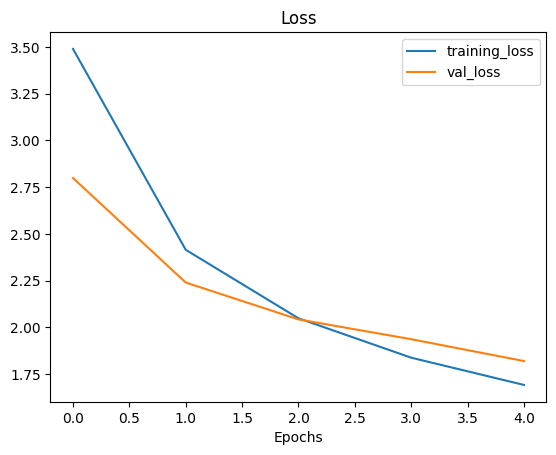

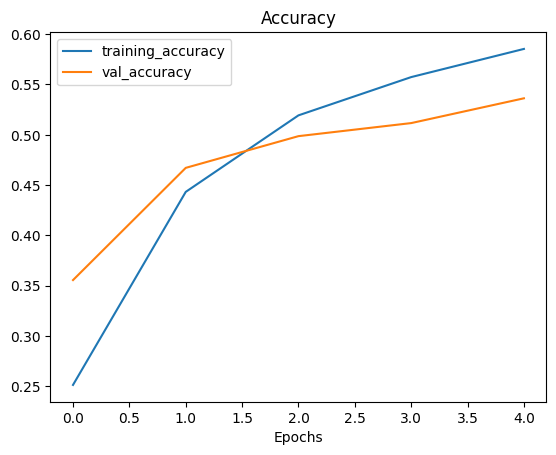

In [23]:
plot_loss_curves(model_all_classes_10_percent)

> ❓ **Question:**  What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing to well on the training data and not generalizing to unseen data)

## Fine-tuning

In [24]:
# Unfreeze all of the layers in the base mdoel

base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [25]:
# Recompile model with lower learnig rate (it's a typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [26]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_average_pooling_layer True
output_layer True


In [27]:
#Check which layers are tarinable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [28]:
# fine-tune for more 5 epochs
fine_tune_epochs = 10

# Fine-tune ou model

history_all_classes_10_percent_fine_tune = model.fit(
    train_data_10_percent,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    initial_epoch=model_all_classes_10_percent.epoch[-1],
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 5/10
237/237 [==============================] - ETA: 0s - loss: 1.4674 - accuracy: 0.6263
Epoch 5: val_accuracy improved from 0.53628 to 0.53734, saving model to 101_food_classes_10_percent_checkpoints_efficientnetv2b0_feature_extract
237/237 [==============================] - 75s 285ms/step - loss: 1.4674 - accuracy: 0.6263 - val_loss: 1.7753 - val_accuracy: 0.5373
Epoch 6/10
237/237 [==============================] - ETA: 0s - loss: 1.3803 - accuracy: 0.6392
Epoch 6: val_accuracy improved from 0.53734 to 0.53761, saving model to 101_food_classes_10_percent_checkpoints_efficientnetv2b0_feature_extract
237/237 [==============================] - 58s 244ms/step - loss: 1.3803 - accuracy: 0.6392 - val_loss: 1.7519 - val_accuracy: 0.5376
Epoch 7/10
237/237 [==============================] - ETA: 0s - loss: 1.3117 - accuracy: 0.6573
Epoch 7: val_accuracy did not improve from 0.53761
237/237 [==============================] - 53s 224ms/step - loss: 1.3117 - accuracy: 0.6573 - val_loss:

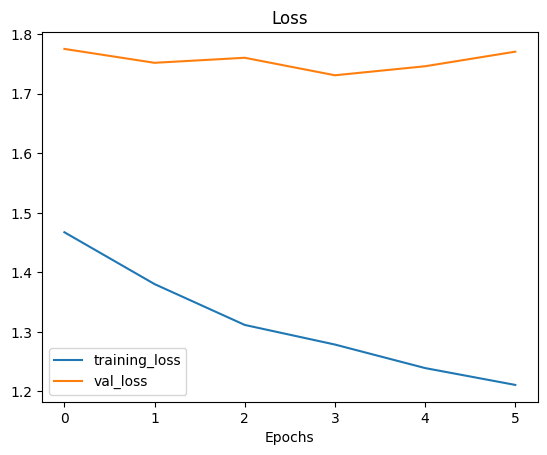

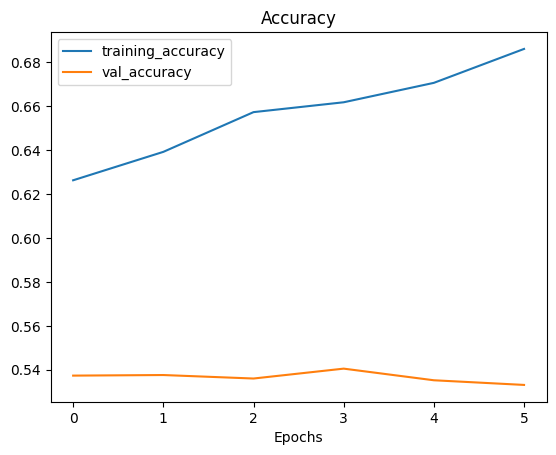

In [29]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

In [31]:
feature_extraction_results = model.evaluate(test_data)

feature_extraction_results

790/790 [==============================] - 37s 47ms/step - loss: 1.4824 - accuracy: 0.6011


[1.4824068546295166, 0.6011484861373901]

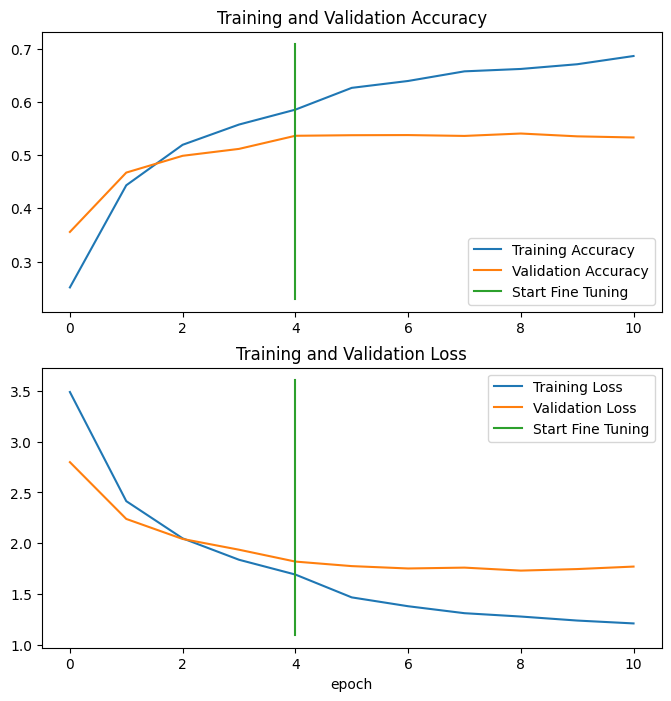

In [32]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(model_all_classes_10_percent, history_all_classes_10_percent_fine_tune)

## Saving and load or model

To use our model in a external application, we'll need to save it and export it somewhere

In [33]:
# Save our fine-tuning model

model.save("drive/MyDrive/tensor_flow_course/101_food_classes_10_percent_fine_tune_saved_big_dog_model")

In [34]:
# Load and evaluate saved model
loaded_saved_model = tf.keras.models.load_model("drive/MyDrive/tensor_flow_course/101_food_classes_10_percent_fine_tune_saved_big_dog_model")

In [35]:
# Evaluate the loaded model and compare performance to pre-saved mdoel
loaded_model_results = loaded_saved_model.evaluate(test_data)

loaded_model_results

790/790 [==============================] - 40s 48ms/step - loss: 1.4824 - accuracy: 0.6011


[1.4824068546295166, 0.6011484861373901]

## Evaluating the performance of the big dog model across alldifferent class

Let's make some predictions, visualize them and then later find outwhich prediciont were the "most" wrong.

In [40]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-05-25 19:38:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  23.1MB/s    in 1.9s    

2024-05-25 19:38:14 (23.1 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [41]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [42]:
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [43]:
# Evaluate loaded mdoel (the one we just downloas on test data)

results_loaded_model = model.evaluate(test_data)

results_loaded_model

790/790 [==============================] - 51s 62ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

[F1 score](https://en.wikipedia.org/wiki/F-score)
[Calculate precision and recall](https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/)
[Calculate accuracy](https://www.omnicalculator.com/statistics/accuracy)